## APAI/STAT 4011 Natural Language Processing

## Assignment 1

### Submission format: 2 files (please don't zip them together), one is the ipynb file implemented with code and comments here, and one is pdf/ html file generated from this notebook. It's highly suggested that you directly write in this notebook.

*The late submission policy*: If you have difficulty handing in on time (e.g., illness etc.), you would need to send the official certificate to Dr. Lau (and cc the tutor Tracy) at least one day before the deadline via email. Otherwise, any late submission is not allowed, and your grade would be counted as 0 for this assignment.

# Part 1: Starting point of the real-life analysis (10 marks)

In this assignment, you would need to perform sentimental analysis on the corpus ***twitter_samples*** from nltk library.

### Q1-1. Load the data to your workspace and print out all the file ids inside twitter_samples. Put all the libraries or packages you would need to use in this assignment here. (2 marks)

In [31]:
# some sample libraries are provided here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
import emoji
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import twitter_samples
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from collections import defaultdict, Counter

nltk.download('punkt')
nltk.download('wordnet')

# print out the file ids
nltk.download('twitter_samples')
file_ids = twitter_samples.fileids()
print(file_ids)

['negative_tweets.json', 'positive_tweets.json', 'tweets.20150430-223406.json']


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\swqwi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\swqwi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\swqwi\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


### Q1-2. Load the negative and positive tweets file to a dataframe with column names {tweet, sentiment} and assign label as 0 for negative, 1 for positive. Print the first 3 rows of your dataframe. (3 marks)

In [32]:
negative_tweets = twitter_samples.strings('negative_tweets.json')
positive_tweets = twitter_samples.strings('positive_tweets.json')

negative_df = pd.DataFrame(negative_tweets, columns=['tweet'])
negative_df['sentiment'] = 0

positive_df = pd.DataFrame(positive_tweets, columns=['tweet'])
positive_df['sentiment'] = 1

tweets_df = pd.concat([negative_df, positive_df], ignore_index=True)
tweets_df.head(3)

,tweet,sentiment
0,hopeless for tmr :(,0
1,Everything in the kids section of IKEA is so c...,0
2,@Hegelbon That heart sliding into the waste ba...,0


### Q1-3. Visualize and comment on the data balance of this dataset. (5 marks)

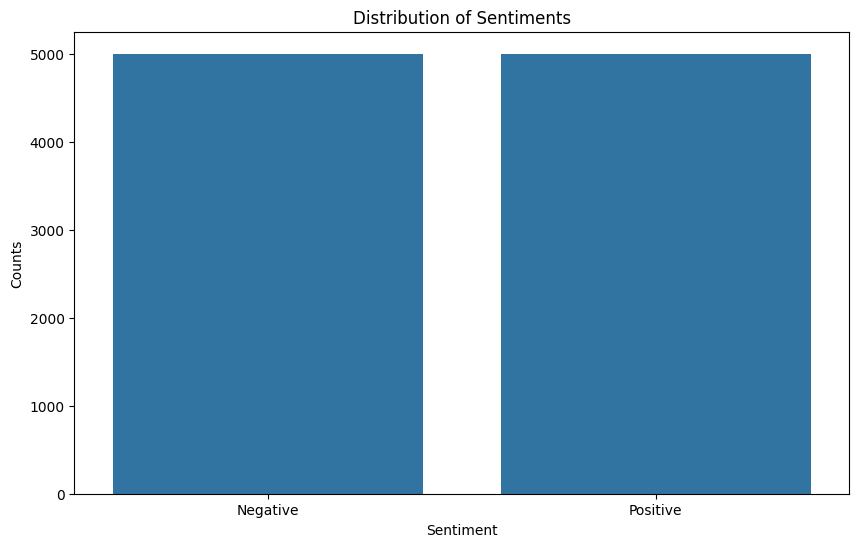

In [33]:
# visualization
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=tweets_df)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()

Your comment here: The ratio of the Positive and Negative sentiment data points are 1:1. A balanced data distribution can prevent bias towards one sentiment over the other, improving the model's generalization.



# Part 2: Text Preprocessing (25 marks)

### Q2-1: The original tweets might be noisy, containing lots of elements that cause mess. Please think of what preprocessing procedure is needed for this specific dataset, and more important, what is the correct order between these steps. The below functions are the ones I think quite important for the data. Please fill in the function defintion, design more functions (if you want) and apply them in the order you decide. The text after processed should be save in a new column named **tidy_tweet**. Please clearly explain the reason you want to add this function, and why you would like to arrange the order like this. For each function, you need to print out the difference before and after the approach by showing the columns {tweet, tidy_tweet} side by side. (14 marks)

Hint: you may need to find some specific tweets to show the difference. If you want to show that your remove_url function is working properly, you may need to find some original tweets containing urls. You may consider controlling this by the random_state parameter or other methods.

In [34]:
def convert_to_lowercase(tweet):
    tweet = tweet.lower()
    return tweet

def emoji_to_word(tweet):
    tweet = emoji.demojize(tweet)
    return tweet

def emoticons_to_word(tweet, emoticon_dict):
    for emoticon, word in emoticon_dict.items():
        tweet = tweet.replace(emoticon, word)
    return tweet

def remove_pattern(tweet, pattern):
    tweet = re.sub(pattern, '', tweet)
    return tweet

def remove_punctuation(tweet):
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    return tweet

def remove_stopwords(tweet):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tweet = ' '.join([word for word in tweet.split() if word not in stop_words])
    return tweet

def remove_urls(tweet):
    tweet = re.sub(r'http\S+', '', tweet)
    return tweet

In [35]:
Emoticon_Dictionary = {
    u":‑\)":"smiley",
    u":\)":"smiley",
    u":-\]":"smiley",
    u":\]":"smiley",
    u":-3":"smiley",
    u":3":"smiley",
    u":->":"smiley",
    u":>":"smiley",
    u"8-\)":"smiley",
    u":o\)":"smiley",
    u":-\}":"smiley",
    u":\}":"smiley",
    u":-\)":"smiley",
    u":c\)":"smiley",
    u":\^\)":"smiley",
    u"=\]":"smiley",
    u"=\)":"smiley",
    u":‑D":"Laughing",
    u":D":"Laughing",
    u"8‑D":"Laughing",
    u"8D":"Laughing",
    u"X‑D":"Laughing",
    u"XD":"Laughing",
    u"=D":"Laughing",
    u"=3":"Laughing",
    u"B\^D":"Laughing",
    u":-\)\)":"happy",
    u":‑\(":"sad",
    u":-\(":"sad",
    u":\(":"sad",
    u":‑c":"sad",
    u":c":"sad",
    u":‑<":"sad",
    u":<":"sad",
    u":‑\[":"sad",
    u":\[":"sad",
    u":-\|\|":"sad",
    u">:\[":"sad",
    u":\{":"sad",
    u":@":"sad",
    u">:\(":"sad",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"happiness",
    u":'\)":"happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"dismay",
    u"D;":"dismay",
    u"D=":"dismay",
    u"DX":"dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"smirk",
    u";\)":"smirk",
    u"\*-\)":"smirk",
    u"\*\)":"smirk",
    u";‑\]":"smirk",
    u";\]":"smirk",
    u";\^\)":"smirk",
    u":‑,":"smirk",
    u";D":"smirk",
    u":‑P":"playful",
    u":P":"playful",
    u"X‑P":"playful",
    u"XP":"playful",
    u":‑Þ":"playful",
    u":Þ":"playful",
    u":b":"playful",
    u"d:":"playful",
    u"=p":"playful",
    u">:P":"playful",
    u":‑/":"annoyed",
    u":/":"annoyed",
    u":-[.]":"annoyed",
    u">:[(\\\)]":"annoyed",
    u">:/":"annoyed",
    u":[(\\\)]":"annoyed",
    u"=/":"annoyed",
    u"=[(\\\)]":"annoyed",
    u":L":"annoyed",
    u"=L":"annoyed",
    u":S":"annoyed",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed",
    u":‑x":"tongue-tied",
    u":x":"tongue-tied",
    u":‑#":"tongue-tied",
    u":#":"tongue-tied",
    u":‑&":"tongue-tied",
    u":&":"tongue-tied",
    u"O:‑\)":"innocent",
    u"O:\)":"innocent",
    u"0:‑3":"innocent",
    u"0:3":"innocent",
    u"0:‑\)":"innocent",
    u"0:\)":"innocent",
    u":‑b":"cheeky",
    u"0;\^\)":"innocent",
    u">:‑\)":"Evil",
    u">:\)":"Evil",
    u"\}:‑\)":"Evil",
    u"\}:\)":"Evil",
    u"3:‑\)":"Evil",
    u"3:\)":"Evil",
    u">;\)":"Evil",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party",
    u"%‑\)":"confused",
    u"%\)":"confused",
    u":-###..":"sick",
    u":###..":"sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous",
    u"\(\^_\^;\)":"Nervous",
    u"\(-_-;\)":"Nervous",
    u"\(~_~;\) \(・\.・;\)":"Nervous",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"respect",
    u"_\(\._\.\)_":"respect",
    u"<\(_ _\)>":"respect",
    u"<m\(__\)m>":"respect",
    u"m\(__\)m":"respect",
    u"m\(_ _\)m":"respect",
    u"\('_'\)":"Sad",
    u"\(/_;\)":"Sad",
    u"\(T_T\) \(;_;\)":"Sad",
    u"\(;_;":"Sad",
    u"\(;_:\)":"Sad",
    u"\(;O;\)":"Sad",
    u"\(:_;\)":"Sad",
    u"\(ToT\)":"Sad",
    u";_;":"Sad",
    u";-;":"Sad",
    u";n;":"Sad",
    u";;":"Sad",
    u"Q\.Q":"Sad",
    u"T\.T":"Sad",
    u"QQ":"Sad",
    u"Q_Q":"Sad",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Laugh",
    u"<\^!\^>":"Laugh",
    u"\^/\^":"Laugh",
    u"\（\*\^_\^\*）" :"Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Laugh",
    u"\(^\^\)":"Laugh",
    u"\(\^\.\^\)":"Laugh",
    u"\(\^_\^\.\)":"Laugh",
    u"\(\^_\^\)":"Laugh",
    u"\(\^\^\)":"Laugh",
    u"\(\^J\^\)":"Laugh",
    u"\(\*\^\.\^\*\)":"Laugh",
    u"\(\^—\^\）":"Laugh",
    u"\(#\^\.\^#\)":"Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Cheerful",
    u"\(\^_\^\)v":"Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed"
}

Emoticon_Dictionary = {re.sub(r'\\(.)', r'\1', key): v for key, v in Emoticon_Dictionary.items()}

In [36]:
tweets_df['tidy_tweet'] = tweets_df['tweet'].apply(convert_to_lowercase)
tweets_df['tidy_tweet'] = tweets_df['tidy_tweet'].apply(emoji_to_word)
tweets_df['tidy_tweet'] = tweets_df['tidy_tweet'].apply(lambda x: emoticons_to_word(x, Emoticon_Dictionary))
tweets_df['tidy_tweet'] = tweets_df['tidy_tweet'].apply(lambda x: remove_pattern(x, r'@\w+'))
tweets_df['tidy_tweet'] = tweets_df['tidy_tweet'].apply(remove_urls)
tweets_df['tidy_tweet'] = tweets_df['tidy_tweet'].apply(remove_punctuation)
tweets_df['tidy_tweet'] = tweets_df['tidy_tweet'].apply(remove_stopwords)

# Print the difference before and after processing
print(tweets_df[['tweet', 'tidy_tweet']])

                                                  tweet  \
0                                   hopeless for tmr :(   
1     Everything in the kids section of IKEA is so c...   
2     @Hegelbon That heart sliding into the waste ba...   
3     “@ketchBurning: I hate Japanese call him "bani...   
4              Dang starting next week I have "work" :(   
...                                                 ...   
9995  @chriswiggin3 Chris, that's great to hear :) D...   
9996  @RachelLiskeard Thanks for the shout-out :) It...   
9997            @side556 Hey!  :)  Long time no talk...   
9998  @staybubbly69 as Matt would say. WELCOME TO AD...   
9999  @DanielOConnel18 you could say he will have eg...   

                                             tidy_tweet  
0                                      hopeless tmr sad  
1     everything kids section ikea cute shame im nea...  
2                        heart sliding waste basket sad  
3                    “ hate japanese call bani sad sad”  
4

### Q2-2: After obtaining the clean text, we would perform stemming or lemmatization on the tweets. Fill in the defintion below and compare the difference between these two methods by creating and printing two columns {stem_tweet, lemm_tweet} side by side. State the reason why you prefer one over another. Choose the one you prefer to apply the procedure on the column {tidy_tweet}. (6 marks)

In [37]:
def stemming(tweet):
    stemmer = PorterStemmer()
    tokens = word_tokenize(tweet)
    return ' '.join([stemmer.stem(token) for token in tokens])

def lemmatization(tweet):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(tweet)
    return ' '.join([lemmatizer.lemmatize(token) for token in tokens])

tweets_df['stem_tweet'] = tweets_df['tidy_tweet'].apply(stemming)
tweets_df['lemm_tweet'] = tweets_df['tidy_tweet'].apply(lemmatization)

print(tweets_df[['stem_tweet', 'lemm_tweet']])

                                             stem_tweet  \
0                                      hopeless tmr sad   
1     everyth kid section ikea cute shame im nearli ...   
2                           heart slide wast basket sad   
3                    “ hate japanes call bani sad sad ”   
4                         dang start next week work sad   
...                                                 ...   
9995  chri that great hear smiley due time amp remin...   
9996                 thank shoutout smiley great aboard   
9997                          hey smiley long time talk   
9998             matt would say welcom adulthood smiley   
9999                          could say egg face smiley   

                                             lemm_tweet  
0                                      hopeless tmr sad  
1     everything kid section ikea cute shame im near...  
2                        heart sliding waste basket sad  
3                    “ hate japanese call ban sad sad ”  
4

Lemmatization is preferred over stemming. Tweets are the data being processed and it usually contains a lot of informal language. Lemmatization maintains the grammatical meaning of words better by maintaining valid word forms instead of chopping off the end of words. Lemmatization also considers part of speech, preserving the context of the tweet, which stemming does not.

### Q2-3: Tokenize the tweets and print out the final dataframe (5 marks)

In [38]:
def tokenization(tweet):
    return word_tokenize(tweet)

tweets_df['tokenized_tweet'] = tweets_df['tidy_tweet'].apply(tokenization)

tweets_df['tokenized_tweet'].sample(10)

6923    [strangely, enough, number, points, youll, get...
550     [need, relaxsad, lungomare, pesaro, giachietit...
1744                          [really, code, monkey, sad]
1318                      [ang, inactive, ko, shems, sad]
9444                                    [friends, smiley]
3725                        [sad, sad, know, goes, still]
6166    [also, want, info, shant, ditching, ill, die, ...
2276                                 [burnt, toffee, sad]
718     [uniting, oppressed, masses, take, forever, sa...
8826       [twine, looking, great, dianes, place, smiley]
Name: tokenized_tweet, dtype: object

In [39]:
column_names = tweets_df.columns

print(column_names)

Index(['tweet', 'sentiment', 'tidy_tweet', 'stem_tweet', 'lemm_tweet',
       'tokenized_tweet'],
      dtype='object')


In [40]:
tweets_df[tweets_df.columns[1:]].sample(10)

,sentiment,tidy_tweet,stem_tweet,lemm_tweet,tokenized_tweet
8256,1,get free gold wot – download world tanks – eas...,get free gold wot – download world tank – easi...,get free gold wot – download world tank – easy...,"[get, free, gold, wot, –, download, world, tan..."
1491,0,cant sleep sad,cant sleep sad,cant sleep sad,"[cant, sleep, sad]"
6501,1,bag job sanza smiley,bag job sanza smiley,bag job sanza smiley,"[bag, job, sanza, smiley]"
1509,0,love sad,love sad,love sad,"[love, sad]"
1231,0,sorry delay naomi sad,sorri delay naomi sad,sorry delay naomi sad,"[sorry, delay, naomi, sad]"
5941,1,new layout looks bomb smiley g,new layout look bomb smiley g,new layout look bomb smiley g,"[new, layout, looks, bomb, smiley, g]"
8373,1,£1590 smiley,£1590 smiley,£1590 smiley,"[£1590, smiley]"
5026,1,hope rest night goes quickly bed got music fix...,hope rest night goe quickli bed got music fix ...,hope rest night go quickly bed got music fix t...,"[hope, rest, night, goes, quickly, bed, got, m..."
7117,1,thank smiley,thank smiley,thank smiley,"[thank, smiley]"
307,0,thats one sweetest things ive ever said awuna ...,that one sweetest thing ive ever said awuna mb...,thats one sweetest thing ive ever said awuna m...,"[thats, one, sweetest, things, ive, ever, said..."


# Part 3: Visualization (15 marks)

### Q3-1: Build and plot the wordcloud for the whole dataset, the negative tweets, and the positive tweets, respectively. Analyze if the result is reasonable. Or if you think there are strange scenarios, what is the possible reasons behind. (5 marks)

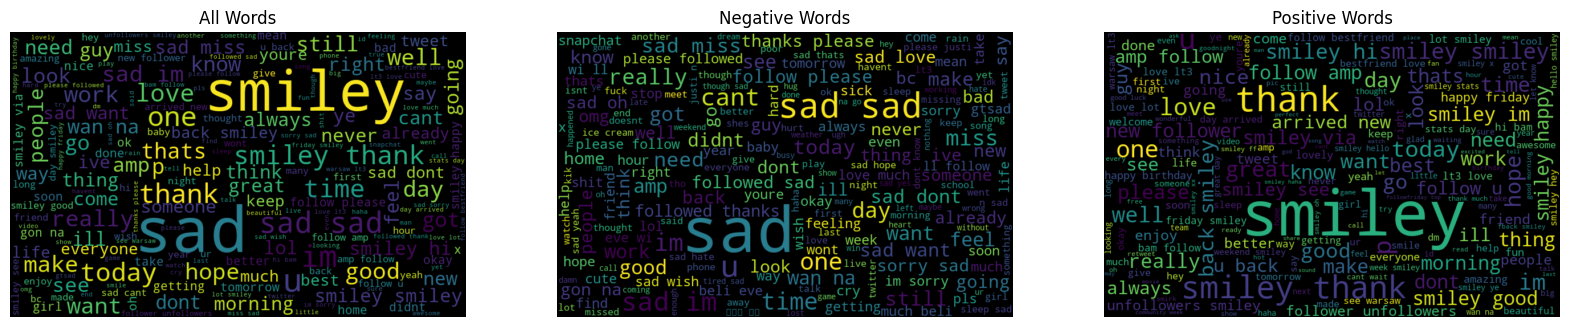

In [41]:
# wordcloud for all
all_words = ' '.join([tweet for tweet in tweets_df['lemm_tweet']])
wordcloud_all = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

# wordcloud for negative
negative_words = ' '.join([tweet for tweet in tweets_df['lemm_tweet'][tweets_df['sentiment'] == 0]])
wordcloud_negative = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)

# wordcloud for positive
positive_words = ' '.join([tweet for tweet in tweets_df['lemm_tweet'][tweets_df['sentiment'] == 1]])
wordcloud_positive = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.title('All Words')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Words')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Words')
plt.axis('off')

plt.show()


### Q3-2: Hashtag might contains important information regarding the sentiment. Build two barplots for the hashtag in negative tweets and positive tweets respectively. What do you find? Do you think hashtag is helpful for our sentimental analysis? (10 marks)

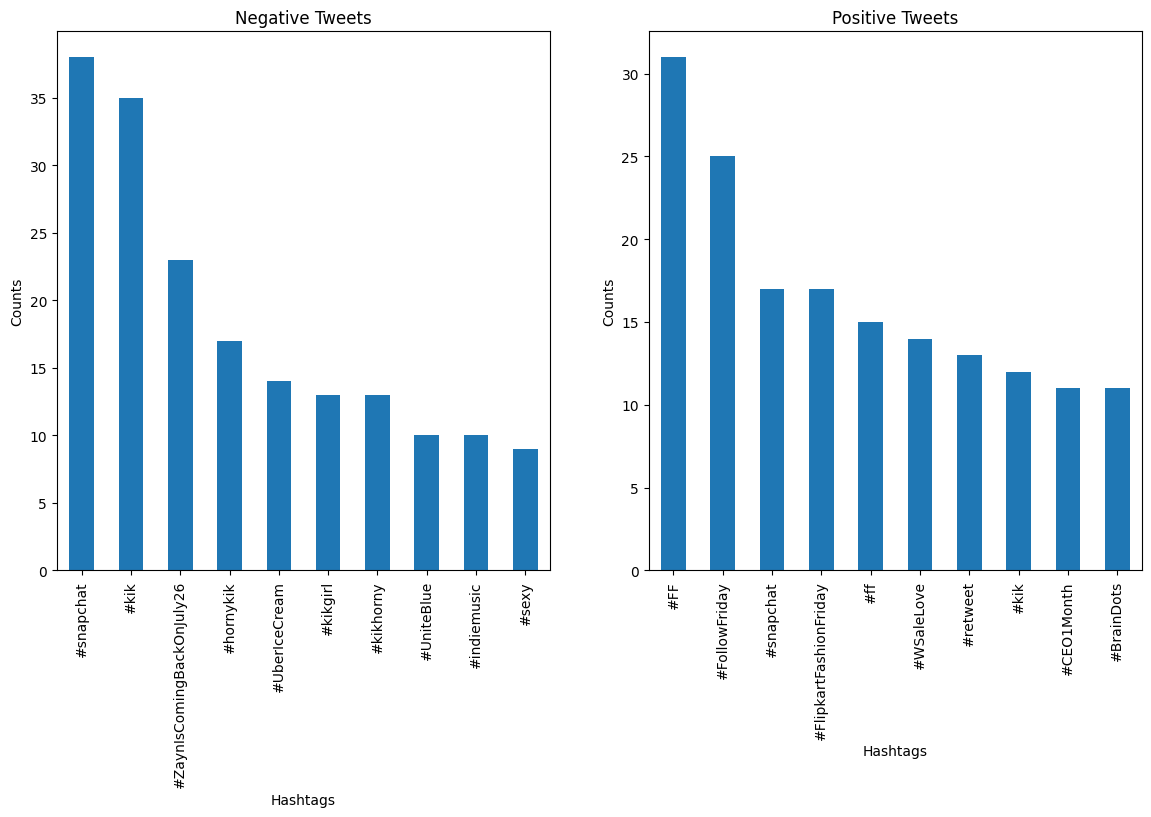

In [42]:
def extract_hashtags(tweet):
    return re.findall(r'#\w+', tweet)

# bar plot for negative
negative_hashtags = tweets_df['tweet'][tweets_df['sentiment'] == 0].apply(extract_hashtags)
negative_hashtags = [item for sublist in negative_hashtags for item in sublist]

# bar plot for positive
positive_hashtags = tweets_df['tweet'][tweets_df['sentiment'] == 1].apply(extract_hashtags)
positive_hashtags = [item for sublist in positive_hashtags for item in sublist]

negative_hashtags = pd.Series(negative_hashtags).value_counts().head(10)
positive_hashtags = pd.Series(positive_hashtags).value_counts().head(10)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
negative_hashtags.plot(kind='bar')
plt.title('Negative Tweets')
plt.xlabel('Hashtags')
plt.ylabel('Counts')

plt.subplot(1, 2, 2)
positive_hashtags.plot(kind='bar')
plt.title('Positive Tweets')
plt.xlabel('Hashtags')
plt.ylabel('Counts')

plt.show()


# Part 4: Modelling (50 marks)

### Q4-1: Divide the dataset into 80% training set and 20% testing set. Perform three types of feature extraction techniques we have covered so far to the dataset for preparation. Clearly state what is the difference between these techniques and which one you expect would be the most appropriate. (5 marks)

In [43]:
# divide the datatset
X = tweets_df['lemm_tweet']
y = tweets_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# feature extraction 1 (TF-IDF)
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# feature extraction 2 (Bag of Words)
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# feature extraction 3 (Bigrams)
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2))
X_train_bigram = bigram_vectorizer.fit_transform(X_train)
X_test_bigram = bigram_vectorizer.transform(X_test)

### Q4-2: Use the sklearn package to implement KNN classifier models with difference number of neighbors. Please use three types of features above, and use the following metrics for comparing the performance: {accuracy, f1, precision, recall}. Write out how the metrics are calculated with formulas (or other ways). Plot the results using line chart, and suggest the best choice for this parameter. (10 marks)

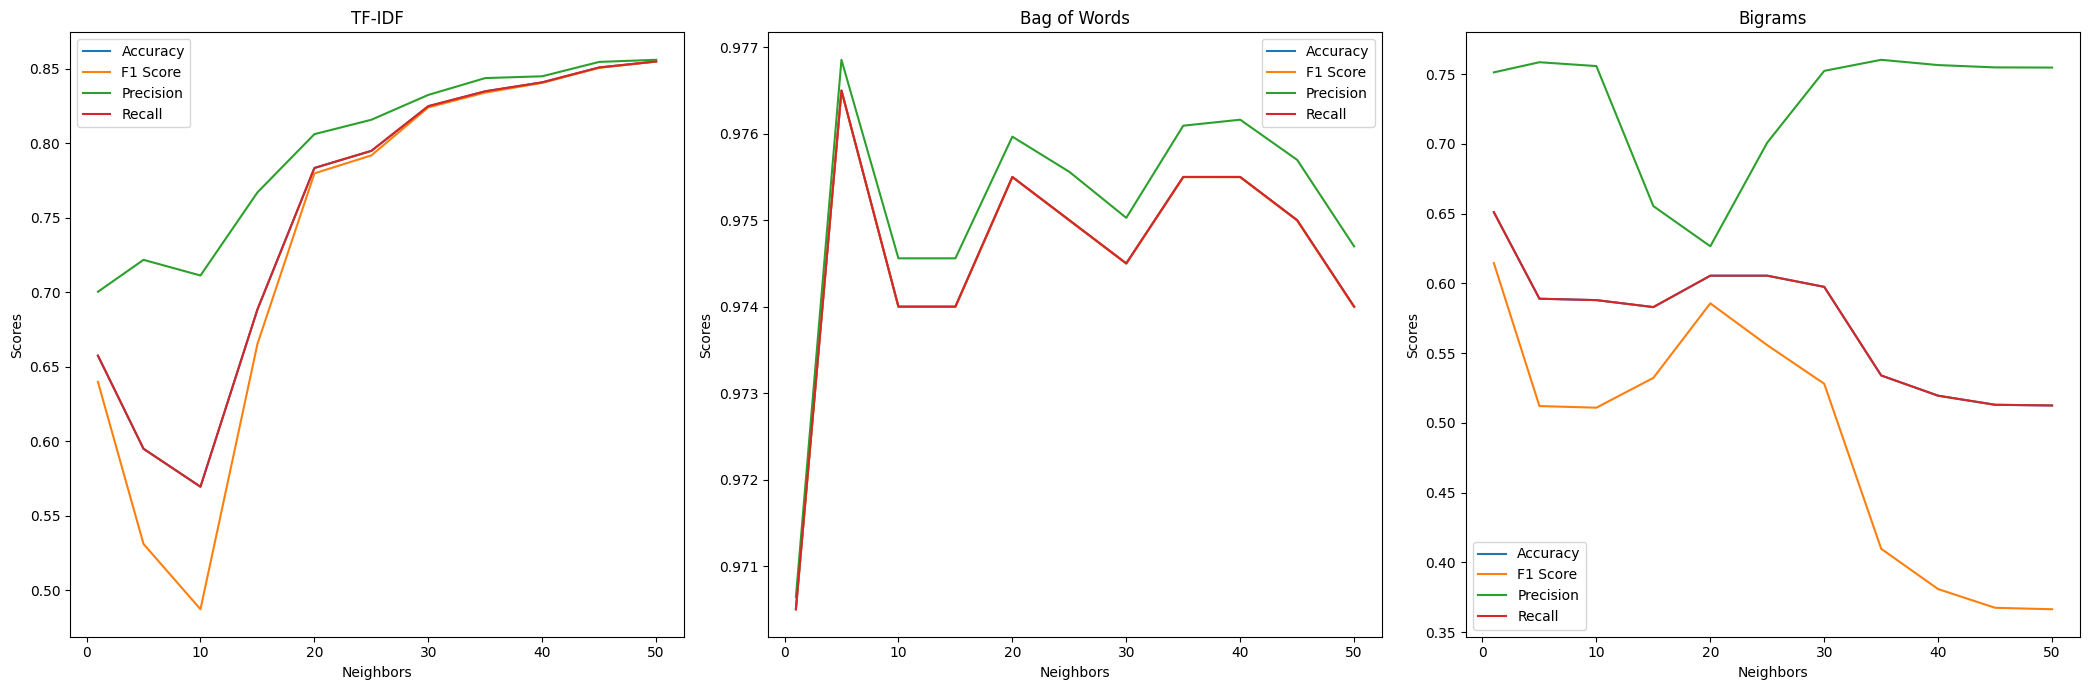

In [45]:
# KNN classifiers with different neighbors (1,2,3,4,... etc)
def knn(X_train, X_test, y_train, y_test, neighbors):
    results = {'accuracy': [], 'f1': [], 'precision': [], 'recall': []}

    for n in neighbors:
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        results['accuracy'].append(accuracy_score(y_test, y_pred))
        results['f1'].append(f1_score(y_test, y_pred, average='weighted'))
        results['precision'].append(precision_score(y_test, y_pred, average='weighted'))
        results['recall'].append(recall_score(y_test, y_pred, average='weighted'))

    return results

# plot a line chart
neighbours = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
results_tfidf = knn(X_train_tfidf, X_test_tfidf, y_train, y_test, neighbours)
results_bow = knn(X_train_bow, X_test_bow, y_train, y_test, neighbours)
results_bigram = knn(X_train_bigram, X_test_bigram, y_train, y_test, neighbours)

plt.figure(figsize=(21, 7))

plt.subplot(1, 3, 1)
plt.plot(neighbours, results_tfidf['accuracy'], label='Accuracy')
plt.plot(neighbours, results_tfidf['f1'], label='F1 Score')
plt.plot(neighbours, results_tfidf['precision'], label='Precision')
plt.plot(neighbours, results_tfidf['recall'], label='Recall')
plt.title('TF-IDF')
plt.xlabel('Neighbors')
plt.ylabel('Scores')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(neighbours, results_bow['accuracy'], label='Accuracy')
plt.plot(neighbours, results_bow['f1'], label='F1 Score')
plt.plot(neighbours, results_bow['precision'], label='Precision')
plt.plot(neighbours, results_bow['recall'], label='Recall')
plt.title('Bag of Words')
plt.xlabel('Neighbors')
plt.ylabel('Scores')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(neighbours, results_bigram['accuracy'], label='Accuracy')
plt.plot(neighbours, results_bigram['f1'], label='F1 Score')
plt.plot(neighbours, results_bigram['precision'], label='Precision')
plt.plot(neighbours, results_bigram['recall'], label='Recall')
plt.title('Bigrams')
plt.xlabel('Neighbors')
plt.ylabel('Scores')
plt.legend()

plt.tight_layout()
plt.show()

For TF-IDF, the best choice for K would be 50. For Bag of Words, the best choice for K would be 5. For Bigrams, the best choice for K would be 20.

### Q4-3: Use the sklearn package to implement Naive Bayes classifier, Logistic regression, and KNN classifier. For KNN, you may directly use the best result above. Again use three types of features above, and use the following metrics for comparing the performance: {accuracy, f1, precision, recall}. Summarize the scores into tables and provide possible reasons that lead to this situation. Is the performance good? Why? (5 marks)

Hint: you should have $3*3*4=36$ outputs. When performing comparison, you could analyze from two views, one is comparing different feature extraction methods while model is the same, another is comparing different models when applying the same feature extraction procedure.

In [46]:
# naive bayes classifier
# logistic regression
# knn
def evaluate_classifier(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted')
    }

# Classifiers
classifiers_bow = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=5)  # Best K for Bag-of-Words
}

classifiers_tfidf = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=50)  # Best K for TF-IDF
}

classifiers_bigram = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=20)  # Best K for Bigrams
}

results_bow = {name: evaluate_classifier(clf, X_train_bow, X_test_bow, y_train, y_test) for name, clf in classifiers_bow.items()}
results_tfidf = {name: evaluate_classifier(clf, X_train_tfidf, X_test_tfidf, y_train, y_test) for name, clf in classifiers_tfidf.items()}
results_bigram = {name: evaluate_classifier(clf, X_train_bigram, X_test_bigram, y_train, y_test) for name, clf in classifiers_bigram.items()}

# Summarize scores into tables
results_bow_df = pd.DataFrame(results_bow).T
results_tfidf_df = pd.DataFrame(results_tfidf).T
results_bigram_df = pd.DataFrame(results_bigram).T

combined_results = pd.concat([results_bow_df, results_tfidf_df, results_bigram_df], keys=['Bag-of-Words', 'TF-IDF', 'Bigrams'])

print("Performance with Bag-of-Words:")
print(results_bow_df)
print("\nPerformance with TF-IDF:")
print(results_tfidf_df)
print("\nPerformance with Bigrams:")
print(results_bigram_df)

Performance with Bag-of-Words:
                     accuracy        f1  precision  recall
Naive Bayes            0.9630  0.962966   0.964140  0.9630
Logistic Regression    0.9790  0.978998   0.979563  0.9790
KNN                    0.9765  0.976500   0.976855  0.9765

Performance with TF-IDF:
                     accuracy        f1  precision  recall
Naive Bayes            0.9195  0.919412   0.920721  0.9195
Logistic Regression    0.9790  0.979000   0.979237  0.9790
KNN                    0.8550  0.854941   0.856131  0.8550

Performance with Bigrams:
                     accuracy        f1  precision  recall
Naive Bayes            0.8220  0.820353   0.836366  0.8220
Logistic Regression    0.8245  0.822608   0.841242  0.8245
KNN                    0.6055  0.585681   0.626567  0.6055


Bag of Words and TF-IDF shows a similar and good performance. While Bigram shows a slightly worse performance. One possible reason is that as Bigrams create a much larger feature space, the dataset may not be large enough which leads to sparsity.

### Q4-4: Write out the procedure how naive bayes classifier is classifying our dataset. Remember to clearly write out the mathematical formulas involved in the procedure. Implement the naive bayes classifier step by step (without directly calling any package). Add clear explanations to your python code based on the procedure you stated above. Compare the results you get here with the one in Q4-3. (15 marks)

Naive Bayes procedure:

In [22]:
# implement naive bayes based on the above procedure
def tokenize(text):
    return text.lower().split()

vocab = set()
for text in X_train:
    vocab.update(tokenize(text))

vocab = list(vocab)

class_counts = y_train.value_counts()
total_count = len(y_train)
priors = {cls: count / total_count for cls, count in class_counts.items()}

likelihoods = {cls: defaultdict(lambda: 1) for cls in class_counts.index}
class_feature_counts = {cls: Counter() for cls in class_counts.index}

for text, label in zip(X_train, y_train):
    tokens = tokenize(text)
    class_feature_counts[label].update(tokens)

    for cls, feature_counts in class_feature_counts.items():
        total_features = sum(feature_counts.values())
        for token in vocab:
            likelihoods[cls][token] = (feature_counts[token] + 1) / (total_features + len(vocab))

def nb_predict(text):
    tokens = tokenize(text)
    posteriors = {}
    for cls in priors:
        prior = np.log(priors[cls])
        likelihood = sum(np.log(likelihoods[cls][token]) for token in tokens if token in vocab)
        posteriors[cls] = prior + likelihood
    return max(posteriors, key=posteriors.get)

predictions = [nb_predict(text) for text in X_test]
accuracy = sum(1 for true, pred in zip(y_test, predictions) if true == pred) / len(y_test)

print("Predictions:", predictions)
print("True Labels:", list(y_test))
print("Accuracy:", accuracy)

Predictions: [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,

The above implementation of Naive Bayes has a lower accuracy score than all the Naive Bayes model in Q4-3. This is to be expected as no featuer extraction is implemented.

### Q4-5: Write out the procedure how logistic regression is working in our case. Remember to clearly write out the mathematical formulas involved in the procedure. Implement the logistic regression using Stochastic Gradient Descent (SGD) step by step (without directly calling any package). Add clear explanations to your python code based on the procedure you stated above. Compare the results you get here with the one in Q4-3.

Logistic regression procedure:


In [47]:
# implement logistic regression based on the above procedure

def tokenize(text):
    return text.lower().split()

vocab = set()
for text in X_train:
    vocab.update(tokenize(text))

vocab = list(vocab)

def text_to_vector(text, vocab):
    vector = np.zeros(len(vocab))
    tokens = tokenize(text)
    for token in tokens:
        if token in vocab:
            vector[vocab.index(token)] = 1
    return vector

X_train_vector = np.array([text_to_vector(text, vocab) for text in X_train])
X_test_vector = np.array([text_to_vector(text, vocab) for text in X_test])

weights = np.zeros(X_train_vector.shape[1])
bias = 0
learning_rate = 0.001
epochs = 100

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

for epoch in range(epochs):
    for i in range(X_train_vector.shape[0]):
        xi = X_train_vector[i]
        yi = y_train.iloc[i]
        z = np.dot(xi, weights) + bias
        prediction = sigmoid(z)
        error = prediction - yi
        weights -= learning_rate * error * xi
        bias -= learning_rate * error

def log_predict(X, weights, bias):
    z = np.dot(X, weights) + bias
    return sigmoid(z) >= 0.5

predictions = log_predict(X_test_vector, weights, bias)
accuracy = np.mean(predictions == y_test)

print("Predictions:", predictions)
print("True Labels:", y_test.values)
print("Accuracy:", accuracy)

Predictions: [ True False False ...  True False  True]
True Labels: [1 0 0 ... 1 0 1]
Accuracy: 0.9785


It appears that even without feature extraction, logistic regression is able to achieve high level of accuracy. It surpassed the accuracy of logistic regression with Bigram and is only slightly lower than that with KNN or BoW.